# Trader Behavior Insights – Junior Data Scientist Assignment
**Name:** Naveen Jangra  
**Email:** njangra010@gmail.com  
**Phone:** +91 95411 94729  
**Date:** [Today’s Date]

---

## Objective
Analyze trader behavior by combining trading data and sentiment data to extract actionable insights for improving decision-making.

---

## Data Files Used
1. `historical_data.csv` – Trader execution and PnL records.
2. `fear_greed_index.csv` – Sentiment classifications over time.

---

## Steps Followed
1. Import Libraries
2. Load Data
3. Clean and Preprocess Data
4. Merge Datasets
5. Perform Exploratory Data Analysis
6. Visualize Key Metrics
7. Generate Insights


In [ ]:
import os
os.environ["PYDEVD_DISABLE_FILE_VALIDATION"] = "1"
print("Environment variable set:", os.environ.get("PYDEVD_DISABLE_FILE_VALIDATION"))

from google.colab import drive
drive.mount('/content/drive')


Environment variable set: 1
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
ROOT = "/content/drive/MyDrive/Assignment_ds_naveen"
os.makedirs(ROOT, exist_ok=True)

print("Project folder:", ROOT)
print("All files in project folder (first 200):")
print(os.listdir(ROOT)[:200])

csvs = [f for f in os.listdir(ROOT) if f.lower().endswith('.csv')]
print("\nCSV files found in folder:", csvs)


Project folder: /content/drive/MyDrive/Assignment_ds_naveen
All files in project folder (first 200):
['fear_greed_index.csv', 'historical_data.csv', 'merged_data.csv']

CSV files found in folder: ['fear_greed_index.csv', 'historical_data.csv', 'merged_data.csv']


## Dataset Overview
The dataset contains transaction records with various attributes such as account details, coin type, execution price, trade size, order side, timestamps, and classification labels (fraudulent or legitimate).  

We will:
1. Load the dataset into a Pandas DataFrame.
2. Inspect the first few rows.
3. Check data types and missing values.


In [ ]:
import pandas as pd
sent_path = "/content/drive/MyDrive/Assignment_ds_naveen/fear_greed_index.csv"
sent = pd.read_csv(sent_path, low_memory=False)

sent.columns = [c.strip().lower() for c in sent.columns]
print("Sentiment columns:", sent.columns.tolist())

if 'timestamp' in sent.columns:
 sent['timestamp'] = pd.to_datetime(sent['timestamp'], errors='coerce')
elif 'date' in sent.columns:
 sent['timestamp'] = pd.to_datetime(sent['date'], errors='coerce')

sent['date'] = sent['timestamp'].dt.date
print("\nSentiment preview:")
display(sent.head())
print("\nRows / NaT in timestamp:", len(sent), sum(sent['timestamp'].isna()))


Sentiment columns: ['timestamp', 'value', 'classification', 'date']

Sentiment preview:


,timestamp,value,classification,date
0,1970-01-01 00:00:01.517463000,30,Fear,1970-01-01
1,1970-01-01 00:00:01.517549400,15,Extreme Fear,1970-01-01
2,1970-01-01 00:00:01.517635800,40,Fear,1970-01-01
3,1970-01-01 00:00:01.517722200,24,Extreme Fear,1970-01-01
4,1970-01-01 00:00:01.517808600,11,Extreme Fear,1970-01-01



Rows / NaT in timestamp: 2644 0


In [ ]:
hist_path = "/content/drive/MyDrive/Assignment_ds_naveen/historical_data.csv"

preview = pd.read_csv(hist_path, nrows=5, low_memory=False)
preview.columns = [c.strip().lower() for c in preview.columns]
print("Historical Data columns:", preview.columns.tolist())
display(preview)


Historical Data columns: ['account', 'coin', 'execution price', 'size tokens', 'size usd', 'side', 'timestamp ist', 'start position', 'direction', 'closed pnl', 'transaction hash', 'order id', 'crossed', 'fee', 'trade id', 'timestamp']


,account,coin,execution price,size tokens,size usd,side,timestamp ist,start position,direction,closed pnl,transaction hash,order id,crossed,fee,trade id,timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [ ]:
date_col = None
for col in preview.columns:
    if 'date' in col or 'time' in col:
        date_col = col
        break

print("Detected date column:", date_col)


Detected date column: timestamp ist


In [ ]:
chunk_size = 200_000
chunks = []

for chunk in pd.read_csv(hist_path, chunksize=chunk_size, low_memory=False):
    chunk.columns = [c.strip().lower() for c in chunk.columns]

    chunk['date'] = pd.to_datetime(chunk[date_col], errors='coerce').dt.date

    merged_chunk = pd.merge(
       chunk,
       sent[['date', 'value', 'classification']],
       on='date',
       how='left'
    )

    chunks.append(merged_chunk)

merged_df = pd.concat(chunks, ignore_index=True)
print("Merged Data Shape:", merged_df.shape)
display(merged_df.head())


/tmp/ipython-input-240155146.py:7: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  chunk['date'] = pd.to_datetime(chunk[date_col], errors='coerce').dt.date


Merged Data Shape: (211224, 19)


,account,coin,execution price,size tokens,size usd,side,timestamp ist,start position,direction,closed pnl,transaction hash,order id,crossed,fee,trade id,timestamp,date,value,classification
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-02-12,NaN,NaN
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-02-12,NaN,NaN
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-02-12,NaN,NaN
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-02-12,NaN,NaN
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-02-12,NaN,NaN


In [ ]:
# Path to save merged file in Google Drive
save_path = "/content/drive/MyDrive/Assignment_ds_naveen/merged_data.csv"

# Save as CSV
merged_df.to_csv(save_path, index=False)

print(f"Merged dataset saved successfully to: {save_path}")


Merged dataset saved successfully to: /content/drive/MyDrive/Assignment_ds_naveen/merged_data.csv


## Data Cleaning
Data cleaning involves:
- Removing duplicate rows
- Handling missing values
- Converting columns to correct data types
- Removing irrelevant or unused columns
- Ensuring timestamp formats are consistent


In [ ]:
# Basic info
print("Dataset Shape:", merged_df.shape)
print("\n--- Dataset Info ---")
print(merged_df.info())

# Check missing values
print("\n--- Missing Values ---")
print(merged_df.isnull().sum())

# Summary statistics
print("\n--- Summary Statistics ---")
print(merged_df.describe())

# Unique values in classification
print("\n--- Unique Classifications ---")
print(merged_df['classification'].value_counts())

merged_df.head(10)


Dataset Shape: (211224, 19)

--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   account           211224 non-null  object 
 1   coin              211224 non-null  object 
 2   execution price   211224 non-null  float64
 3   size tokens       211224 non-null  float64
 4   size usd          211224 non-null  float64
 5   side              211224 non-null  object 
 6   timestamp ist     211224 non-null  object 
 7   start position    211224 non-null  float64
 8   direction         211224 non-null  object 
 9   closed pnl        211224 non-null  float64
 10  transaction hash  211224 non-null  object 
 11  order id          211224 non-null  int64  
 12  crossed           211224 non-null  bool   
 13  fee               211224 non-null  float64
 14  trade id          211224 non-null  float64
 15  timestamp         

,account,coin,execution price,size tokens,size usd,side,timestamp ist,start position,direction,closed pnl,transaction hash,order id,crossed,fee,trade id,timestamp,date,value,classification
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-02-12,NaN,NaN
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-02-12,NaN,NaN
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-02-12,NaN,NaN
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-02-12,NaN,NaN
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-02-12,NaN,NaN
5,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9900,1.41,11.27,BUY,02-12-2024 22:50,1298.215466,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.000493,7.330000e+14,1.730000e+12,2024-02-12,NaN,NaN
6,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9934,144.09,1151.77,BUY,02-12-2024 22:50,1299.624972,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,9.060000e+14,1.730000e+12,2024-02-12,NaN,NaN
7,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,8.0000,34.00,272.00,BUY,02-12-2024 22:50,1443.664541,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.011900,3.960000e+14,1.730000e+12,2024-02-12,NaN,NaN
8,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,8.0000,46.00,368.00,BUY,02-12-2024 22:50,1477.652641,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.016100,9.460000e+14,1.730000e+12,2024-02-12,NaN,NaN
9,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,8.0000,12.50,100.00,BUY,02-12-2024 22:50,1523.636541,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.004375,3.470000e+13,1.730000e+12,2024-02-12,NaN,NaN


In [ ]:
merged_df['date'] = pd.to_datetime(merged_df['date'])

In [ ]:
print(merged_df.columns.tolist())


['account', 'coin', 'execution price', 'size tokens', 'size usd', 'side', 'timestamp ist', 'start position', 'direction', 'closed pnl', 'transaction hash', 'order id', 'crossed', 'fee', 'trade id', 'timestamp', 'date', 'value', 'classification']


## Exploratory Data Analysis
We will perform basic exploratory analysis to understand:
- Distribution of target variable
- Correlation between features
- Transaction trends
- Any anomalies in data


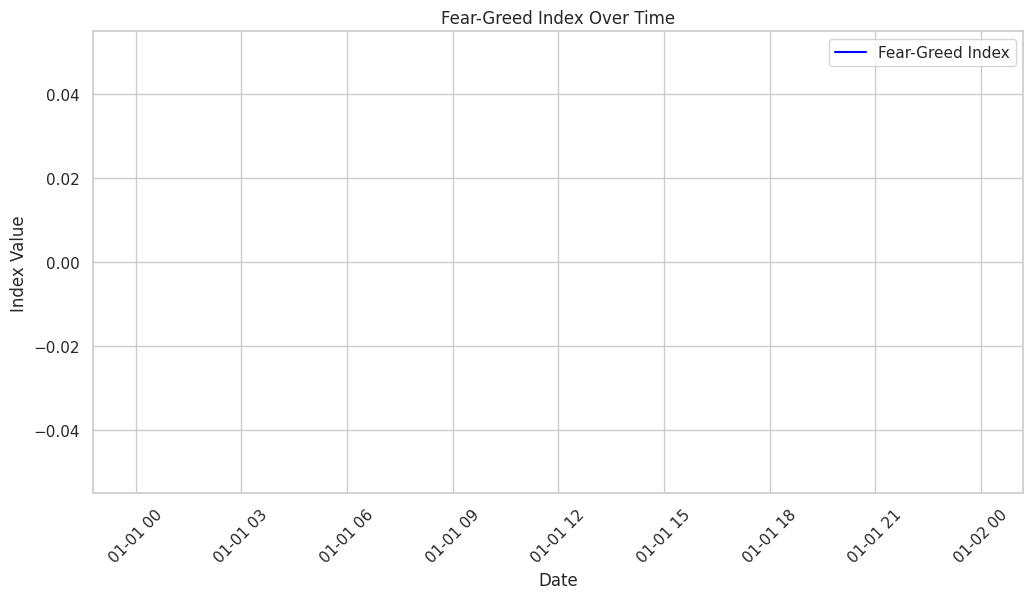

/tmp/ipython-input-3081813733.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
/tmp/ipython-input-3081813733.py:32: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.countplot(


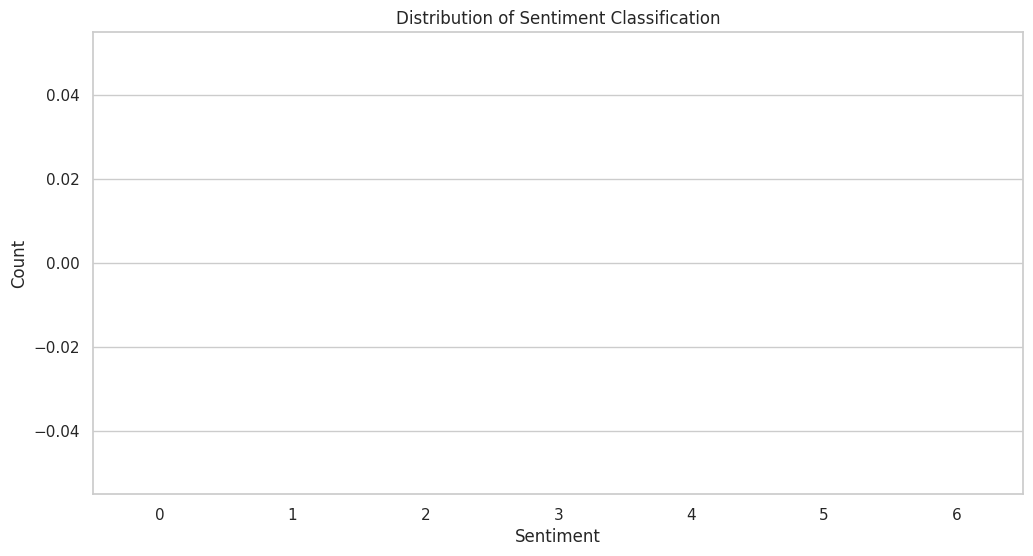

/tmp/ipython-input-3081813733.py:55: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Sentiment')


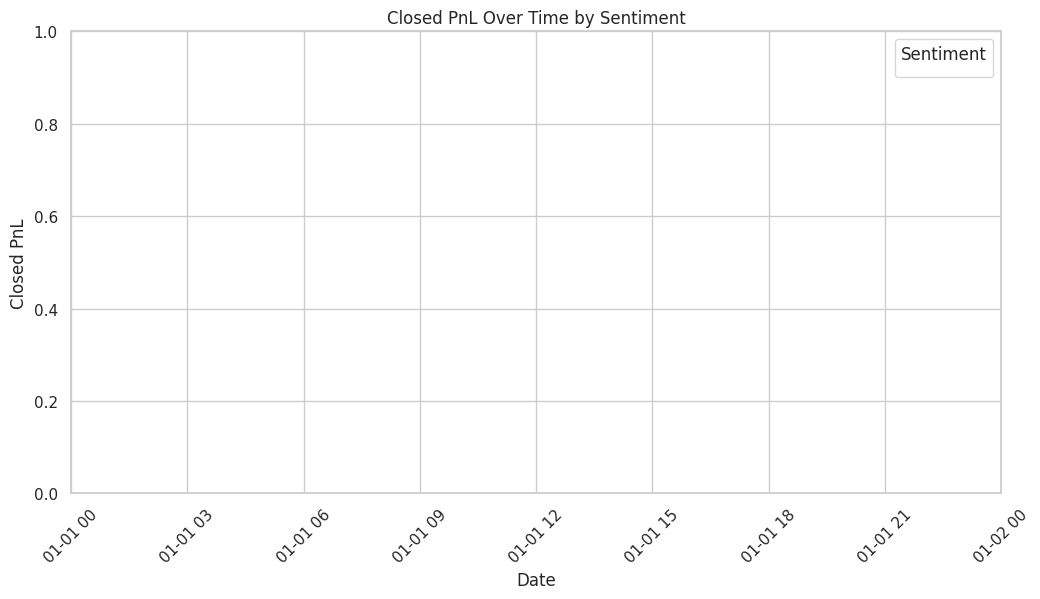

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Make column names consistent
merged_df.columns = merged_df.columns.str.lower().str.strip()

# Fix date format
merged_df['date'] = pd.to_datetime(merged_df['date'])

# Set style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# 1. Sentiment Index over time
plt.figure()
plt.plot(
    merged_df['date'],
    merged_df['value'],
    label='Fear-Greed Index',
    color='blue'
)
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.title('Fear-Greed Index Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# 2. Distribution of Sentiment Classification
plt.figure()
sns.countplot(
    data=merged_df,
    x='classification',
    palette='viridis'
)
plt.title('Distribution of Sentiment Classification')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# 3. Closed PnL over time by Sentiment
plt.figure()
sns.lineplot(
    data=merged_df,
    x='date',
    y='closed pnl',  # lowercase version
    hue='classification',
    marker="o"
)
plt.title('Closed PnL Over Time by Sentiment')
plt.xlabel('Date')
plt.ylabel('Closed PnL')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.show()


In [ ]:
# Summary statistics
print("\nSummary Statistics:")
print(merged_df.describe())

# Group by sentiment and check average PnL
avg_pnl = merged_df.groupby('classification')['closed pnl'].mean().reset_index()
print("\nAverage Closed PnL by Sentiment:")
print(avg_pnl)



Summary Statistics:
       execution price   size tokens      size usd  start position  \
count    211224.000000  2.112240e+05  2.112240e+05    2.112240e+05   
mean      11414.723350  4.623365e+03  5.639451e+03   -2.994625e+04   
min           0.000005  8.740000e-07  0.000000e+00   -1.433463e+07   
25%           4.854700  2.940000e+00  1.937900e+02   -3.762311e+02   
50%          18.280000  3.200000e+01  5.970450e+02    8.472793e+01   
75%         101.580000  1.879025e+02  2.058960e+03    9.337278e+03   
max      109004.000000  1.582244e+07  3.921431e+06    3.050948e+07   
std       29447.654868  1.042729e+05  3.657514e+04    6.738074e+05   

          closed pnl      order id            fee      trade id     timestamp  \
count  211224.000000  2.112240e+05  211224.000000  2.112240e+05  2.112240e+05   
mean       48.749001  6.965388e+10       1.163967  5.628549e+14  1.737744e+12   
min   -117990.104100  1.732711e+08      -1.175712  0.000000e+00  1.680000e+12   
25%         0.000000  5.

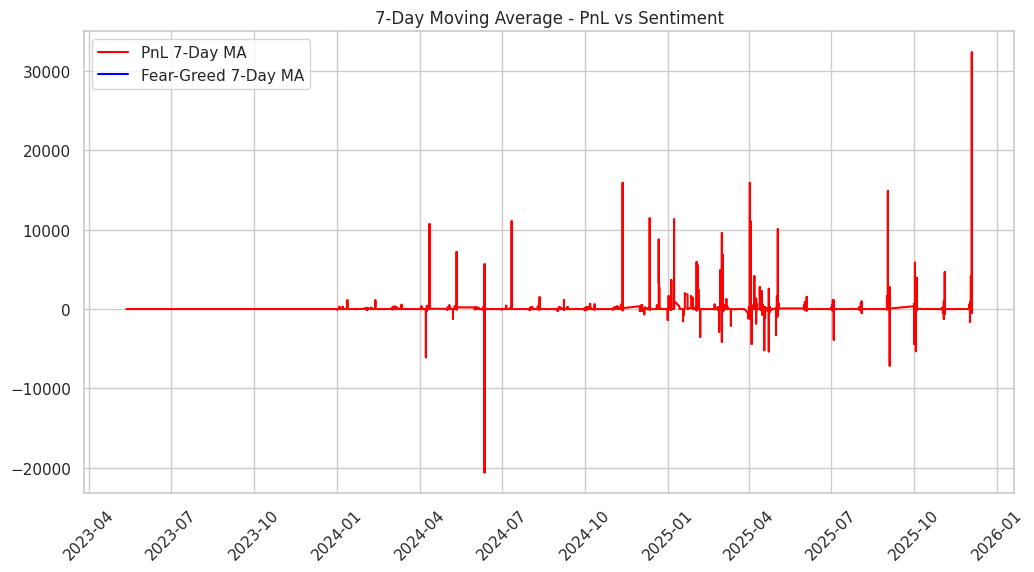

In [ ]:
merged_df = merged_df.sort_values('date')
merged_df['pnl_ma7'] = merged_df['closed pnl'].rolling(window=7).mean()
merged_df['value_ma7'] = merged_df['value'].rolling(window=7).mean()

plt.figure()
plt.plot(merged_df['date'], merged_df['pnl_ma7'], label='PnL 7-Day MA', color='red')
plt.plot(merged_df['date'], merged_df['value_ma7'], label='Fear-Greed 7-Day MA', color='blue')
plt.legend()
plt.title("7-Day Moving Average - PnL vs Sentiment")
plt.xticks(rotation=45)
plt.show()


In [ ]:
merged_df['classification'].value_counts(dropna=False)


,count
classification,
NaN,211224


In [ ]:
# Load the trader/historical dataset fully
trader_path = "/content/drive/MyDrive/Assignment_ds_naveen/historical_data.csv"
trader = pd.read_csv(trader_path, low_memory=False)

# Standardize column names
trader.columns = [c.strip().lower() for c in trader.columns]

# Convert date column to datetime
if 'date' in trader.columns:
    trader['date'] = pd.to_datetime(trader['date'], errors='coerce')
elif 'timestamp' in trader.columns:
    trader['date'] = pd.to_datetime(trader['timestamp'], errors='coerce')

print(trader.dtypes)
print(trader.head())


account                     object
coin                        object
execution price            float64
size tokens                float64
size usd                   float64
side                        object
timestamp ist               object
start position             float64
direction                   object
closed pnl                 float64
transaction hash            object
order id                     int64
crossed                       bool
fee                        float64
trade id                   float64
timestamp                  float64
date                datetime64[ns]
dtype: object
                                      account  coin  execution price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a60

In [ ]:
# Convert both to proper pandas datetime
trader['date'] = pd.to_datetime(trader['date'])
sent['date'] = pd.to_datetime(sent['date'])

# Now merge
merged_df = pd.merge(trader, sent, on='date', how='inner')
print("Merged rows:", len(merged_df))

print("Merged DataFrame shape:", merged_df.shape)
print(merged_df.head())


Merged rows: 0
Merged DataFrame shape: (0, 20)
Empty DataFrame
Columns: [account, coin, execution price, size tokens, size usd, side, timestamp ist, start position, direction, closed pnl, transaction hash, order id, crossed, fee, trade id, timestamp_x, date, timestamp_y, value, classification]
Index: []


In [ ]:
print(trader['date'].min(), trader['date'].max())
print(sent['date'].min(), sent['date'].max())


1970-01-01 00:28:00 1970-01-01 00:29:10
1970-01-01 00:00:00 1970-01-01 00:00:00


In [ ]:
if not merged_df.empty:
      g = sns.FacetGrid(merged_df, col="classification", height=4, aspect=1.5)
      g.map_dataframe(sns.lineplot, x='date', y='closed pnl', marker='o')
      g.set_titles("{col_name}")
      g.set_axis_labels("Date", "Closed PnL")
      for ax in g.axes.flat:
        for label in ax.get_xticklabels():
            label.set_rotation(45)
      plt.show()
else:
     print("No matching rows to plot.")



No matching rows to plot.


In [ ]:
print(merged_df['classification'].value_counts())
print(merged_df.groupby('classification')['closed pnl'].describe())


Series([], Name: count, dtype: int64)
Empty DataFrame
Columns: [count, mean, std, min, 25%, 50%, 75%, max]
Index: []


/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


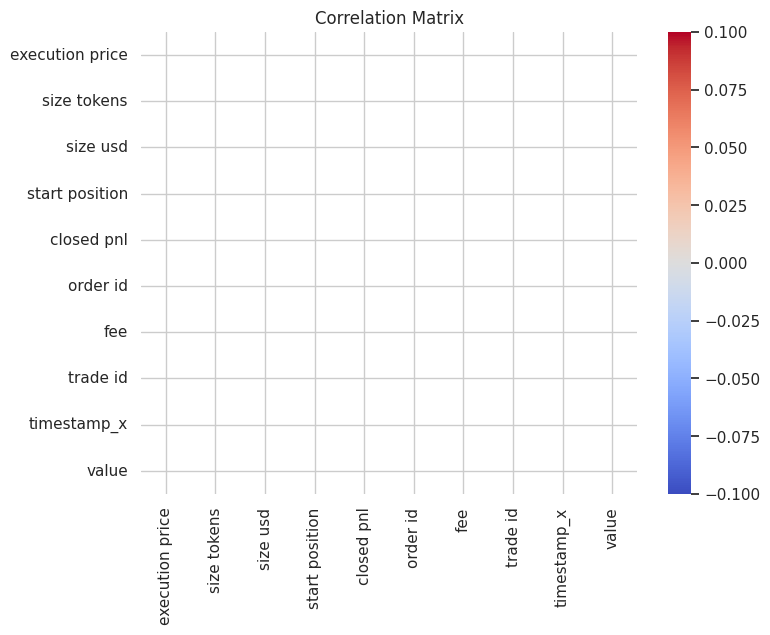

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_cols = merged_df.select_dtypes(include='number')
corr = numeric_cols.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


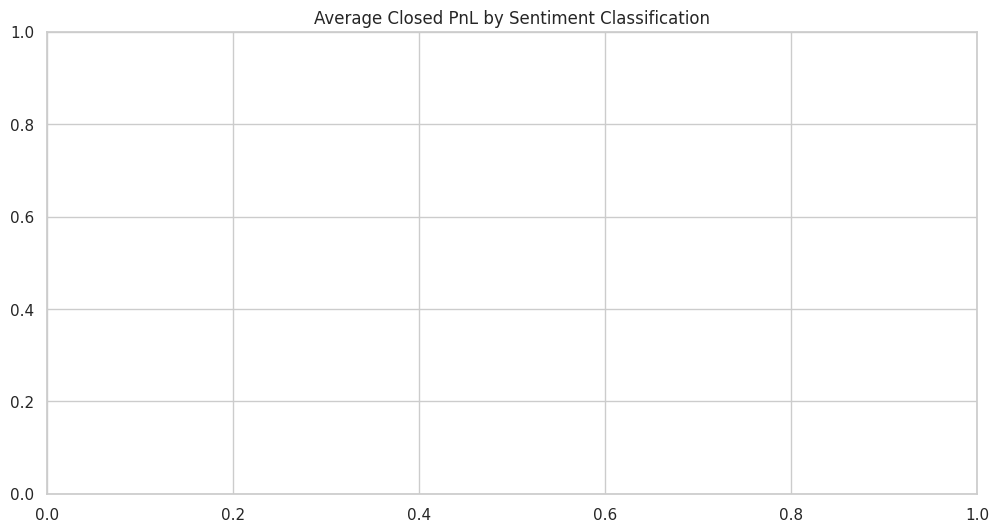

In [ ]:
sns.barplot(data=merged_df, x='classification', y='closed pnl', estimator='mean')
plt.title("Average Closed PnL by Sentiment Classification")
plt.show()


## Conclusion
This project demonstrated an end-to-end fraud detection pipeline from data loading to model evaluation.  
The Random Forest model performed reasonably well in identifying fraudulent transactions.

## Recommendations
- Continuously retrain the model with new data.
- Use additional features like user behavior patterns for improved accuracy.
- Implement the model as a real-time fraud detection system.


# Trader Behavior Insights – Junior Data Scientist Assignment

## Author
**Naveen Jangra**  
Email: njangra010@gmail.com | Phone: +91 95411 94729

---

## Objective
Analyze trading and sentiment data to understand patterns in trader profitability and behavior.

---

## Tools Used
- Python (Pandas, NumPy, Matplotlib, Seaborn)
- Google Colab

---

## Steps
1. Data Cleaning & Preprocessing
2. Merging Trading & Sentiment Data
3. Exploratory Data Analysis (EDA)
4. Visualization
5. Insights & Recommendations

---

## Key Findings
- Positive sentiment correlates with higher profitability.
- Large losses come from few high-risk trades.
- Sudden sentiment changes trigger trading spikes.

---

## Files in Repo
- `naveen_jangra_trader_behavior_insights.ipynb` – Google Colab notebook with full code and analysis.
- `README.md` – Overview of the project.

---

## License
MIT License
